Mean Squared Error (MSE): 192.71172344927405


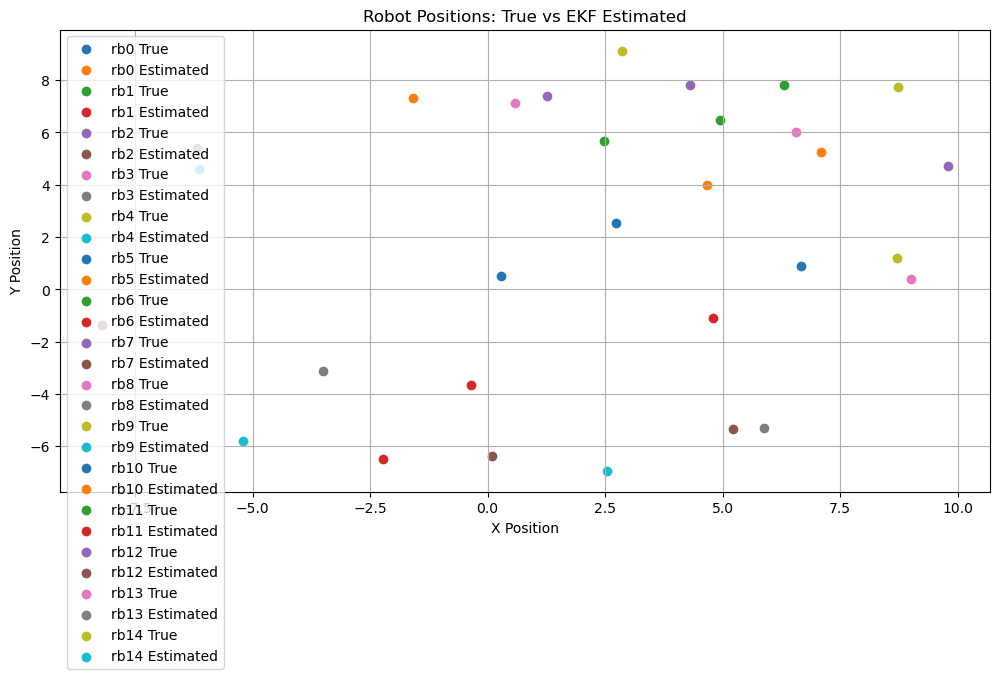

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class Robot:
    def __init__(self, id, x, y, std_noise):
        self.id = id
        self.x = x  
        self.y = y  
        self.state = np.array([[x], [0], [y], [0]])  # state: [x_position, x_velocity, y_position, y_velocity]
        self.P = np.eye(4) * 100  
        self.std_noise = std_noise
        self.Q = np.eye(4) * std_noise**2  
        self.neighbors = []
        self.measurements = []

    def update_neighbors(self, robots):
        self.neighbors = [robot for robot in robots if robot.id != self.id]

    def predict(self, dt):
        F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]]) 
        self.state = F.dot(self.state)
        self.P = F.dot(self.P).dot(F.T) + self.Q

    def update(self):
        for measurement in self.measurements:
            z, R, H = measurement
            y = z - H.dot(self.state)  
            S = H.dot(self.P).dot(H.T) + R  
            K = self.P.dot(H.T).dot(np.linalg.inv(S)) 
            self.state = self.state + K.dot(y)
            self.P = (np.eye(4) - K.dot(H)).dot(self.P)

    def make_measurements(self, robots, dt):
        self.measurements = []
        for robot in robots:
            if robot is not self:
                dx = robot.x - self.x
                dy = robot.y - self.y
                dist = np.sqrt(dx**2 + dy**2)
                z = np.array([[dist + np.random.normal(0, self.std_noise)]])
                H = np.array([[dx / dist, 0, dy / dist, 0]])
                R = np.array([[self.std_noise**2]])
                self.measurements.append((z, R, H))

    def distance_to(self, other_robot):
        return np.linalg.norm(self.state[[0, 2]] - other_robot.state[[0, 2]])

class Environment:
    def __init__(self, num_robots, std_noise, dt):
        self.num_robots = num_robots
        self.std_noise = std_noise
        self.dt = dt
        self.robots = [Robot(f"rb{i}", np.random.uniform(0, 10), np.random.uniform(0, 10), std_noise) for i in range(num_robots)]
        self.true_positions = {robot.id: (robot.x, robot.y) for robot in self.robots}

    def run_simulation(self, num_iterations):
        for _ in range(num_iterations):
            for robot in self.robots:
                robot.predict(self.dt)
                robot.make_measurements(self.robots, self.dt)
            for robot in self.robots:
                robot.update()

    def calculate_mse(self):
        errors = []
        for robot in self.robots:
            true_x, true_y = self.true_positions[robot.id]
            estimated_x, estimated_y = robot.state[0, 0], robot.state[2, 0]
            errors.append((true_x - estimated_x)**2 + (true_y - estimated_y)**2)
        return np.mean(errors)

    def plot_robots(self):
        plt.figure(figsize=(12, 6))
        for robot in self.robots:
            plt.scatter(*self.true_positions[robot.id], label=f"{robot.id} True")
            plt.scatter(robot.state[0], robot.state[2], label=f"{robot.id} Estimated")
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Robot Positions: True vs EKF Estimated')
        plt.legend()
        plt.grid(True)
        plt.show()

num_robots = 15
std_noise = 0.1
dt = 1
num_iterations = 5


env = Environment(num_robots, std_noise, dt)
env.run_simulation(num_iterations)
mse = env.calculate_mse()
print(f"Mean Squared Error (MSE): {mse}")
env.plot_robots()
